# Auditing Bias

## Abstract

I analyze the predicition of employment status and audit for racial bias for residents of Massachussetts in 2023.

In [337]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MA" # My state

data_source = ACSDataSource(survey_year='2023', # Get more recent data
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTRNS,LANX,MAR,...,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2023GQ0000077,1,1,503,1,25,1019518,11,89,1,NaN,NaN,1.0,1,1,1.0,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0,2,2,1,2,2,2,2,0.0,NaN,NaN,NaN,2.0,2,...,13,13,12,13,12,13,13,13,13,13,13,13,13,12,12,11,13,14,13,12,13,11,12,11,13,12,15,12,11,13,12,13,13,13,13,13,13,12,13,13
1,P,2023GQ0000098,1,1,613,1,25,1019518,11,20,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,1.0,5,...,21,13,2,2,10,21,1,19,10,11,11,13,12,9,3,19,11,11,21,11,12,21,11,13,19,11,11,11,18,1,3,4,2,20,13,9,2,20,13,2
2,P,2023GQ0000109,1,1,613,1,25,1019518,80,68,1,NaN,NaN,2.0,1,2,1.0,1.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,0,2,2,1,1,2,2,2,0.0,NaN,NaN,NaN,2.0,5,...,94,90,84,78,95,95,84,95,94,87,82,80,84,91,78,90,85,94,95,27,16,22,81,25,66,16,81,69,70,79,28,34,78,73,34,68,82,15,17,79
3,P,2023GQ0000114,1,1,801,1,25,1019518,69,21,1,NaN,2.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,20.0,1.0,1.0,2.0,5,...,132,64,62,12,135,12,12,68,77,129,132,9,60,63,57,9,69,67,62,58,69,130,12,75,71,73,63,132,123,78,60,74,161,11,127,57,11,12,11,12
4,P,2023GQ0000135,1,1,1201,1,25,1019518,27,84,1,NaN,NaN,2.0,2,1,2.0,2.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0,2,2,1,2,2,2,2,0.0,NaN,NaN,NaN,2.0,1,...,27,29,27,25,29,30,29,29,29,29,26,27,27,27,27,27,27,29,28,27,25,27,26,27,27,25,28,28,24,27,27,28,27,29,27,29,27,27,28,27


In [338]:
# No RELP avaiable 
possible_features=['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,89,16.0,2,1,NaN,1,1.0,4.0,3,1,1,1,1.0,2,1,6.0
1,20,16.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,9,6.0
2,68,18.0,5,1,NaN,1,1.0,4.0,1,1,1,2,2.0,1,1,6.0
3,21,19.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,1.0
4,84,16.0,1,1,NaN,1,3.0,4.0,3,1,2,1,1.0,2,1,6.0


## Model

### Feature selection And Data Split

In [339]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [340]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)

(73126, 14)
(73126,)
(73126,)


In [341]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

### Basic Descriptives

In [342]:

import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["race"] = group_train
df["label"] = y_train

relabeled = df.copy() # this is save to the original in case I need it later
relabeled['race'] = relabeled['race'].replace({1: "White", 2: "Black", 3: "N. American", 4:"N. Alaskan", 
                      5:"SPAA", 
                      6:'Asian', 7: 'NPI', 8:'Other', 9: 'Multi'})

relabeled['race'] = pd.Categorical(relabeled['race'])

print(relabeled.head())


   AGEP  SCHL  MAR  DIS  ESP  CIT  ...  DEAR  DEYE  DREM  SEX   race  label
0  69.0  19.0  1.0  2.0  0.0  1.0  ...   2.0   2.0   2.0  2.0  White  False
1  10.0   7.0  5.0  2.0  1.0  1.0  ...   2.0   2.0   2.0  1.0  White  False
2  14.0  10.0  5.0  1.0  1.0  1.0  ...   2.0   2.0   1.0  1.0  Other  False
3  55.0   1.0  5.0  2.0  0.0  4.0  ...   2.0   2.0   2.0  1.0  White   True
4  42.0  23.0  5.0  2.0  0.0  1.0  ...   2.0   2.0   2.0  1.0  White   True

[5 rows x 16 columns]


1. The number of indiviuals in this df are

In [343]:
print("The number of indiviuals in this df are", df.shape[0])

The number of indiviuals in this df are 58500


2. The proportion of employed individuals are 

In [344]:
emp = df[df['label'] == True][["label"]].size # 29703
total = df['label'].size # 58500
emp_prop = emp / total
print("The proportion of employed indiviuals are", emp_prop)

The proportion of employed indiviuals are 0.5077435897435898


3. The proportion of employed people in each group are:

In [345]:
relabeled.groupby('race')[['label']].aggregate('mean')

/var/folders/t8/bssz0nhj0h94fjkhfd648d280000gn/T/ipykernel_70250/802482079.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  relabeled.groupby('race')[['label']].aggregate('mean')


,label
race,
Asian,0.540315
Black,0.473668
Multi,0.456270
N. American,0.530612
NPI,0.625000
Other,0.486364
SPAA,0.520000
White,0.514687


4. Intersectional Trends

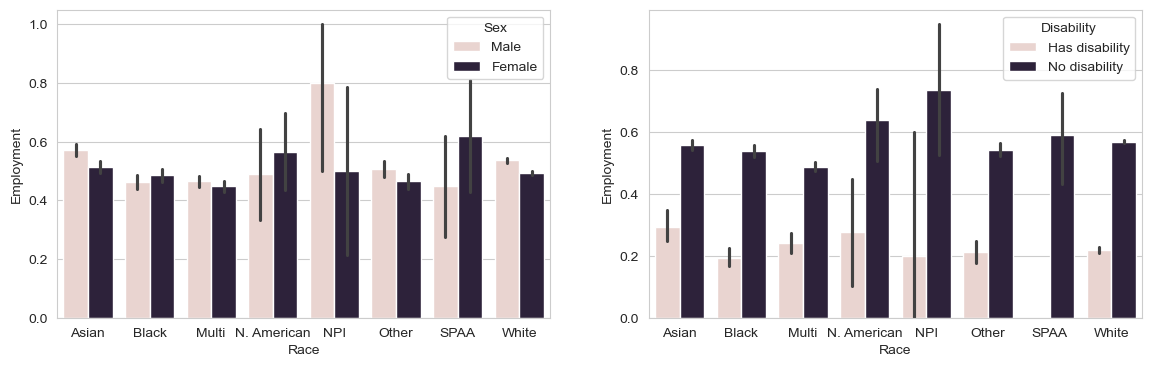

In [346]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (14, 4))

plt1 = sns.barplot(relabeled, x = "race", y = "label", hue="SEX", ax=ax[0])
plt1.set_xlabel("Race")
plt1.set_ylabel("Employment")
handles, _ = plt1.get_legend_handles_labels()
plt1.legend(handles=handles, title='Sex', labels=['Male', 'Female'])

plt2 = sns.barplot(relabeled, x = "race", y = "label", hue="DIS", ax=ax[1])
plt2.set_xlabel("Race")
plt2.set_ylabel("Employment")
handles, _ = plt2.get_legend_handles_labels()
plt2.legend(handles=handles, title='Disability', labels=['Has disability', 'No disability'])
plt.show()

In this we see intersectionality between sex of the person and whether they have a disability. As we can see in both graphs generally male and able bodied people are more likely to be employed. It is important to recogonize that we also I'm not sure how many of both groups. More females are more likely to be doing childcare at home and depending on disability people may not apply for jobs at all. It is interesting that for American Indians and Alaskan Natives more women are employed more than men. 

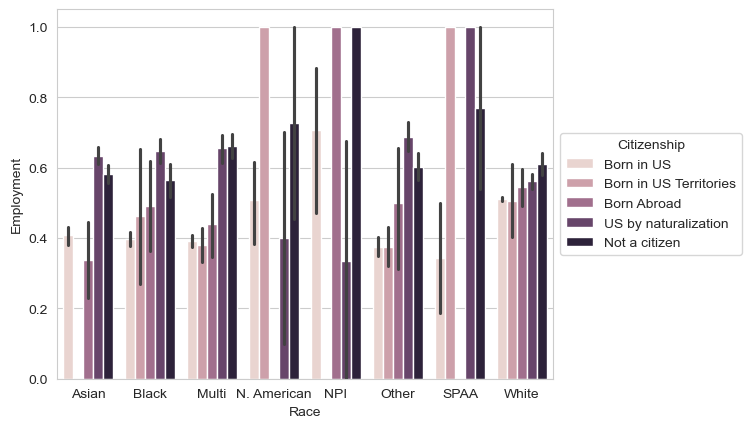

In [347]:
plt3 = sns.barplot(relabeled, x = "race", y = "label", hue="CIT")
plt3.set_xlabel("Race")
plt3.set_ylabel("Employment")
handles, _ = plt3.get_legend_handles_labels()
status = ['Born in US', 'Born in US Territories', 'Born Abroad', 'US by naturalization', 'Not a citizen']
plt3.legend(handles=handles, title='Citizenship', labels=status, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In this graph, we see that for people born in the U.S or it's territories have lower percentage employment than people born abroad or by naturalization. I suspect this is due to population numbers and people who move here for specific work purposes.   

### Training Model

The decision tree classifier was one of the recommedations and scikit learn said it was easy to interpret. In order to find the best depth for I used GridSearchCV which cross validated the best paramaters.

In [348]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

param_grid = {
    'max_depth': [1, 3, 5, 10]
}

model = DecisionTreeClassifier() 
grid = GridSearchCV(model, param_grid, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best params", grid.best_params_)

best_dtree = grid.best_estimator_

best_dtree.predict(X_train)
best_dtree.score(X_train, y_train)

Best params {'max_depth': 10}


0.8346666666666667

### Testing model

In [349]:
pred = best_dtree.predict(X_test)

## Bias Audit

### Overall Measures

The overall accuracy:

In [350]:
(pred == y_test).mean()

np.float64(0.8216874059893341)

Here we calculate the PPV, the false negative and false positive rate

In [351]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

ppv = tp / (tp + fp)
fnr = fn / (fn + tp)
fpr = tp / (tp + tn)

print("Overall PPV:", ppv)
print("Overall false negative rate:", fnr)
print("Overall false positive rate:", fpr)


Overall PPV: 0.7936899186591078
Overall false negative rate: 0.12666124220233252
Overall false positive rate: 0.5358628723581295


### By-Group Measures

This is the accuracy by group:

In [352]:
groups = df["race"].unique() # Need race as numbers in order to compare with group_test
audit = pd.DataFrame(groups, columns=["race"])

accuracies = []
for group in groups:
   accuracy = (pred == y_test)[group_test == group].mean()
   accuracies.append(accuracy)

audit["accuracy"] = accuracies
audit


,race,accuracy
0,1,0.824056
1,8,0.808511
2,9,0.825095
3,2,0.797212
4,6,0.820998
5,7,0.500000
6,5,1.000000
7,3,0.812500


This is the PPV, the false negative and false positive rate by group:

In [353]:
ppvs = []
tprs = []


fnrs = []
fprs = []

for group in groups:
    tp = int(0)
    fp = int(0)
    tn = int(0)
    fn = int(0)
    for n, m, grp in zip(y_test, pred, group_test):
        if(grp == group):
            if m == n:
                if n == True:
                    tp += 1
                if n == False:
                    tn += 1
            if m != n:
                if n == True:
                    fn += 1
                if n == False:
                    fp += 1
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    ppvs.append(ppv)
    fnr = fn / (fn + tp)  if (fn + tp) > 0 else 0
    fnrs.append(fnr)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0 
    fprs.append(fpr)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tprs.append(tpr)
    

audit["ppv"] = ppvs
audit["tpr"] = tprs

audit["fpr"] = fprs
audit["fnr"] = fnrs
audit.set_index("race", inplace=True)
audit.sort_index(inplace=True)
audit



,accuracy,ppv,tpr,fpr,fnr
race,,,,,
1,0.824056,0.802288,0.868737,0.222350,0.131263
2,0.797212,0.737327,0.874317,0.269504,0.125683
3,0.812500,0.625000,1.000000,0.272727,0.000000
5,1.000000,0.000000,0.000000,0.000000,0.000000
6,0.820998,0.806495,0.901664,0.285429,0.098336
7,0.500000,0.000000,0.000000,0.000000,1.000000
8,0.808511,0.752525,0.889552,0.264865,0.110448
9,0.825095,0.769345,0.873311,0.214385,0.126689


### Bias Measures

Approximately calibrated:

In [354]:
cal = pd.DataFrame(pred)
cal["prediction"] = pred
cal.groupby("prediction").count()

,0
prediction,
False,6512
True,8114


This table shows that values either True or False, therefore they this model is calibrated.

Approximate error balance rate: Looking at the table dataframe above we can see that the model does not meet approximate error rate balance for groups. The groups differ in true and false positive rates.

Statistical parity:

In [355]:
probs = []
for group in groups:
    prob = (pred == True)[group_test == group].mean()
    probs.append(prob)

ind = pd.DataFrame(groups, columns=["race"])
ind["prob"] = probs
ind.set_index("race", inplace=True)
ind.sort_index(inplace=True)
ind

,prob
race,
1,0.551662
2,0.550063
3,0.500000
5,0.000000
6,0.635972
7,0.000000
8,0.561702
9,0.511027


The model does not meet statistical parity.

In [356]:
audit.reset_index(inplace=True)
print(audit)

   race  accuracy       ppv       tpr       fpr       fnr
0     1  0.824056  0.802288  0.868737  0.222350  0.131263
1     2  0.797212  0.737327  0.874317  0.269504  0.125683
2     3  0.812500  0.625000  1.000000  0.272727  0.000000
3     5  1.000000  0.000000  0.000000  0.000000  0.000000
4     6  0.820998  0.806495  0.901664  0.285429  0.098336
5     7  0.500000  0.000000  0.000000  0.000000  1.000000
6     8  0.808511  0.752525  0.889552  0.264865  0.110448
7     9  0.825095  0.769345  0.873311  0.214385  0.126689


In [357]:
audit['race'] = audit['race'].replace({1: "White", 2: "Black", 3: "N. American", 4:"N. Alaskan", 
                      5:"SPAA", 
                      6:'Asian', 7: 'NPI', 8:'Other', 9: 'Multi'})

audit['race'] = pd.Categorical(audit['race'])
audit

,race,accuracy,ppv,tpr,fpr,fnr
0,White,0.824056,0.802288,0.868737,0.222350,0.131263
1,Black,0.797212,0.737327,0.874317,0.269504,0.125683
2,N. American,0.812500,0.625000,1.000000,0.272727,0.000000
3,SPAA,1.000000,0.000000,0.000000,0.000000,0.000000
4,Asian,0.820998,0.806495,0.901664,0.285429,0.098336
5,NPI,0.500000,0.000000,0.000000,0.000000,1.000000
6,Other,0.808511,0.752525,0.889552,0.264865,0.110448
7,Multi,0.825095,0.769345,0.873311,0.214385,0.126689


Add prevalance to data table

In [358]:
audit["p"] = (1 + (audit["tpr"] / audit["fpr"]) * ((1 - audit["ppv"])/(audit["ppv"]))) ** -1
audit["p"] = audit["p"].fillna(0)
audit


,race,accuracy,ppv,tpr,fpr,fnr,p
0,White,0.824056,0.802288,0.868737,0.222350,0.131263,0.509466
1,Black,0.797212,0.737327,0.874317,0.269504,0.125683,0.463878
2,N. American,0.812500,0.625000,1.000000,0.272727,0.000000,0.312500
3,SPAA,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Asian,0.820998,0.806495,0.901664,0.285429,0.098336,0.568847
5,NPI,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000
6,Other,0.808511,0.752525,0.889552,0.264865,0.110448,0.475177
7,Multi,0.825095,0.769345,0.873311,0.214385,0.126689,0.450190


Here I plot the feasibility of FPR and FNR for Black and White groups.

      race       fnr       fpr
0    White  0.000000  0.255946
1    White  0.010101  0.253361
2    White  0.020202  0.250776
3    White  0.030303  0.248191
4    White  0.040404  0.245605
..     ...       ...       ...
195  Black  0.959596  0.008615
196  Black  0.969697  0.006461
197  Black  0.979798  0.004308
198  Black  0.989899  0.002154
199  Black  1.000000  0.000000

[200 rows x 3 columns]


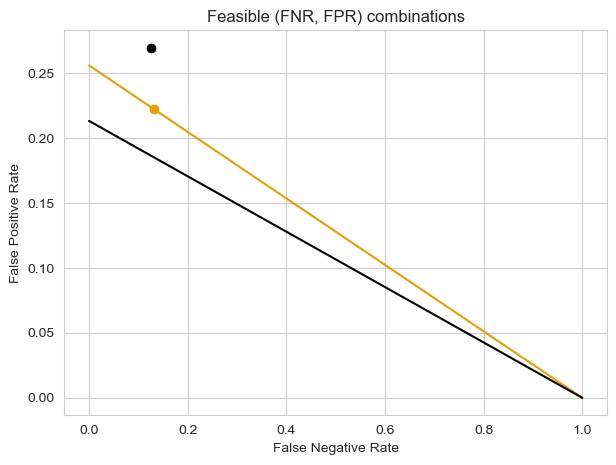

In [ ]:
import seaborn as sns

# Filter to only include Black and White groups
filtered = audit[audit["race"].isin(["Black", "White"])]
# print(filtered)

orange_color = "#E69F00"
black_color = "#000000"

# A cleaner table
feasible = filtered[["race", "fpr", "fnr", "p"]].copy() 

lines = []
p_values = []

# Make fixed ppv based on the white ppv
fixed_ppv = filtered.loc[filtered["race"] == "White", "ppv"].values[0]
fnr_range = np.linspace(0, 1, 100)


for i, row in feasible.iterrows():
    race = row["race"]
    p = row["p"]  # Prevalence is fixed per group
    
    # Compute feasible FPR for different FNR values
    fprs = (p / (1 - p)) * ((1 - fixed_ppv) / fixed_ppv) * (1 - fnr_range)

    for fnr_val, fpr_val in zip(fnr_range, fprs):
        lines.append({"race": race, "fnr": fnr_val, "fpr": fpr_val})

# Convert list to DataFrame
lines_df = pd.DataFrame(lines)

plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

# Plot observed (fnr, fpr)
for i, row in feasible.iterrows():
    color = orange_color if row["race"] == "White" else black_color
    plt.scatter(row["fnr"], row["fpr"], color=color)

# Plot feasible (fnr, fpr) line
for race, color in zip(["White", "Black"]):
    color = orange_color if race == "White" else black_color
    subset = lines_df[lines_df["race"] == race]
    plt.plot(subset["fnr"], subset["fpr"], color=color)


     

plt.xlabel("False Negative Rate")
plt.ylabel("False Positive Rate")
plt.title("Feasible (FNR, FPR) combinations")
plt.show()

To get equal false positive rates, we would need to change the FNR 

## Concluding Discussion

1. Maybe something like a bank(if they didn't know about employment/income), if a person is unemployed than banks are likely to predict whether someone defaults on loan.

2. 

3. Based on the test for statistical parity and error rate balance the results are very close to each other, but not exact to each other. The prediction of empolyment is not independent of race and means that some groups are more likely to be misclassified than others.

4. I don't know if this is a bias but for people in smaller groups this doesn't work very well. If we look at accuracy and rates for Native Americans/Alaskans and Pacific Islanders, our we get NA values or 0's that which oversimplifies we might be going on. 